
# xgBoost学习笔记

- toc: true
- branch: master
- badges: true
- use_math: true
- comments: true
- categories: [StatQuest,xgBoost]
- description: 学习StatQuest的https://www.youtube.com/watch?v=GrJP9FLV3FE 教程记录
---


### 背景

来源: [XGBoost in Python from Start to Finish](https://www.youtube.com/watch?v=GrJP9FLV3FE)

### Introduction
* importing data from a file
* missing data
* xgBoost data format
* building a model
* optimizing a model

### 混淆矩阵(Confusion Matrix)

* rows: Predict result
* columns: Actual result
* outputs: TP/TN/FP/FN

In [ ]:
# install needed modules
!pip install pandas numpy sklearn xgboost fsspec matplotlib ipympl

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgboost

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix

### Import the data

In [ ]:
# download the data
!wget 'https://raw.githubusercontent.com/bhargitay/telco_customer_churn/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [8]:
# read by pandas
df = pd.read_csv('G://temp//WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [9]:
# show datafram
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
# drop unwanted column
# axis=1 -> column inplace -> update the dataframe
df.drop(['customerID'], axis=1, inplace=True)

In [10]:
# find those only contains unique value
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [11]:
# remove space from column names and values
df['MultipleLines'].replace(' ', '_', regex=True, inplace=True)
df.columns = df.columns.str.replace(' ', '_')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No_phone_service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No_phone_service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
# remove all space from data
df.replace(' ', '_', regex=True, inplace=True)

### Missing data
Missing data就是类似NA, 或者空白字符的字段. 在xgBoost中, Missing data应该置为0.

为查找Missing data, 使用`dtypes`方法:

In [15]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

对所有类型为object的列, 逐项检查是否合理.

找到不合理的列及可能有问题的值后, 找到这些值的位置:

In [16]:
# find location
df.loc[(df['TotalCharges'] == ' ')]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [18]:
# set to 0
df.loc[(df['TotalCharges'] == ' '), 'TotalCharges'] = 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

### xgBoost data format
首先将特征和估计值分开:

In [20]:
X = df.drop('Churn', axis=1).copy()
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [21]:
y = df['Churn'].copy()
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

其次, 将Category特征转化为One-hot编码. One-hot编码的原因是它能保证所有目标值互相之间的距离相同, 从而避免模型不必要地拉近不同预测值的距离. 用`get_dummies`转化one-hot编码.

In [23]:
y_encoded=pd.get_dummies(y)['Yes']

In [24]:
X_encoded=pd.get_dummies(X, columns=['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'])

In [25]:
X_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [26]:
y_encoded.unique()

array([0, 1], dtype=uint8)

> tips: 默认值设置为0在one-hot编码中的优势 - 默认值为0会将所有位置的编码都设置为0, 从而使得0不会干扰到其它有实际值的项目.

### build xgBoost model
首先, 将数据划分为训练集 和 测试集. 划分集合时, 需要注意按照目标预测值的比例来进行划分, 保证划分后的比例与划分前尽量一致:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, random_state=42, stratify=y_encoded)

In [29]:
print(len(X_train), len(X_test))

5282 1761


接下来开始构建xgBoost模型.
* early stop: 如果10棵树都没有产生优化效果, 则退出

In [43]:
clf_xgb = xgboost.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test, y_test)])

C:\Users\henryalps\Anaconda3\envs\xeus-python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.63160
[1]	validation_0-aucpr:0.64538
[2]	validation_0-aucpr:0.64402
[3]	validation_0-aucpr:0.64429
[4]	validation_0-aucpr:0.63866
[5]	validation_0-aucpr:0.63419
[6]	validation_0-aucpr:0.63912
[7]	validation_0-aucpr:0.63787
[8]	validation_0-aucpr:0.63779
[9]	validation_0-aucpr:0.63894
[10]	validation_0-aucpr:0.63680


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

最后绘制confusion matrix:

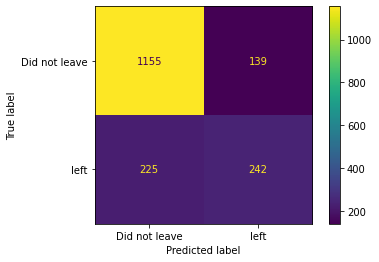

In [44]:
%matplotlib inline
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', display_labels=['Did not leave','left'])

### optimize xgBoost model

模型对left的分类并不好, 但是left的影响更大, 所以需要对模型进行优化. 优化可以通过结合`Cross validation`和`GridSearch`两种方法来达成.

In [ ]:
# GridSearch
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate': [0.1,0.01,0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1,3,5]
}

# 使用subsample参数, 可以指定每棵树对应的样本数量占整体的比重
# 使用colsample_bytree, 可以指定每棵树选取多少特征
# 使用cv, 可指定cross validation是多少折
optimal_params = GridSearchCV(estimator=xgboost.XGBClassifier(objective='binary:logistic',
                                                             seed=42,
                                                             subsample=0.9,
                                                             colsample_bytree=0.5),
                             param_grid=param_grid,
                             scoring='roc_auc',
                             cv=3)